In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import  keras

In [3]:
TRAIN_DIR = "/content/drive/MyDrive/dataset/train"
VALIDATION_DIR = "/content/drive/MyDrive/dataset/val"
BATCH_SIZE = 32
IMAGE_SIZE =(224,224)

# Data Distribution

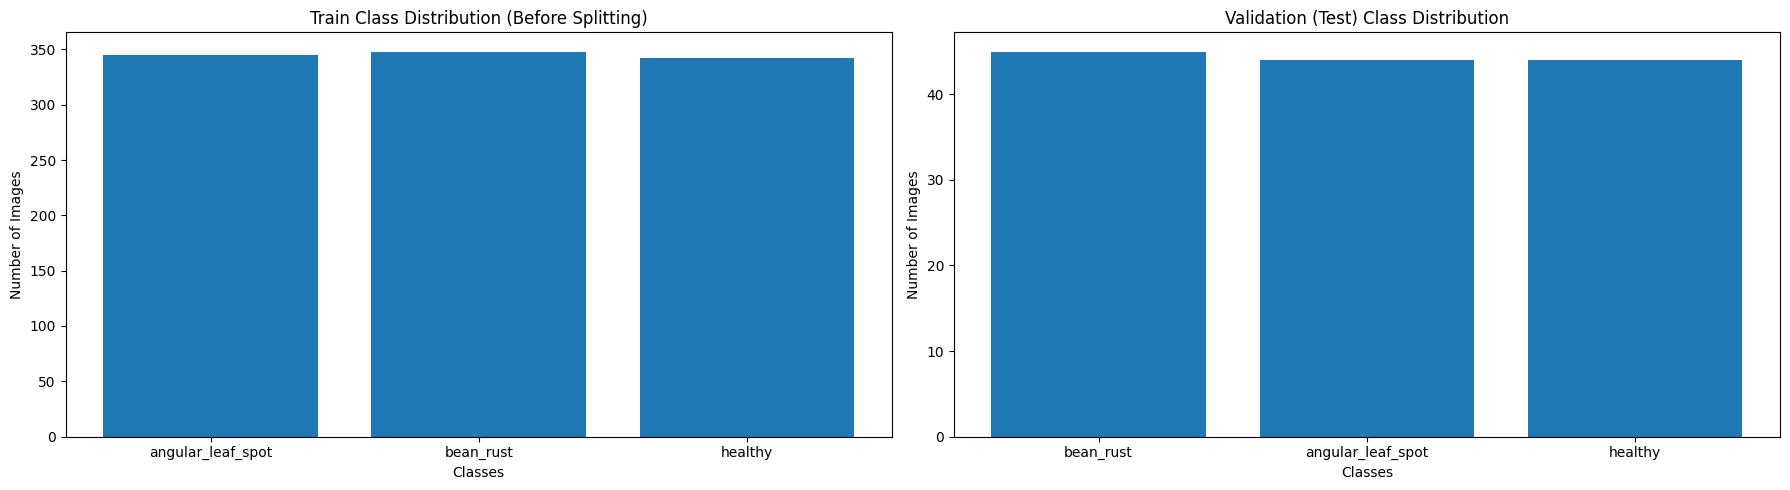

In [4]:
import os
import matplotlib.pyplot as plt

def count_images_in_folders(path):
    class_counts = {}
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_folder] = num_images
    return class_counts

train_counts = count_images_in_folders(TRAIN_DIR)
validation_counts = count_images_in_folders(VALIDATION_DIR)

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].bar(train_counts.keys(), train_counts.values())
ax[0].set_title('Train Class Distribution (Before Splitting)')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Number of Images')

ax[1].bar(validation_counts.keys(), validation_counts.values())
ax[1].set_title('Validation (Test) Class Distribution')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Data Splitting

In [5]:
def create_train_val_datasets(train_dir, image_size, batch_size):
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=train_dir,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='int',
        shuffle=True,
        seed=123
    )

    total_batches = len(full_dataset)
    train_size = int(total_batches * 0.8)

    train_dataset = full_dataset.take(train_size)
    validation_dataset = full_dataset.skip(train_size)

    return train_dataset, validation_dataset

def create_test_dataset(val_dir, image_size, batch_size):
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=val_dir,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='int',
        shuffle=False
    )
    return test_dataset

train_dataset, val_dataset = create_train_val_datasets(TRAIN_DIR, IMAGE_SIZE, BATCH_SIZE)
test_dataset = create_test_dataset(VALIDATION_DIR, IMAGE_SIZE, BATCH_SIZE)

print(f"Train dataset: {len(train_dataset)} batches")
print(f"Validation dataset: {len(val_dataset)} batches")
print(f"Test dataset: {len(test_dataset)} batches")

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Train dataset: 26 batches
Validation dataset: 7 batches
Test dataset: 5 batches


# Augmentation

In [6]:
def create_augmentation_model():


    augmentation_model = tf.keras.Sequential([
        tf.keras.Input(shape=(224,224, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomZoom(0.1)
    ])

    return augmentation_model



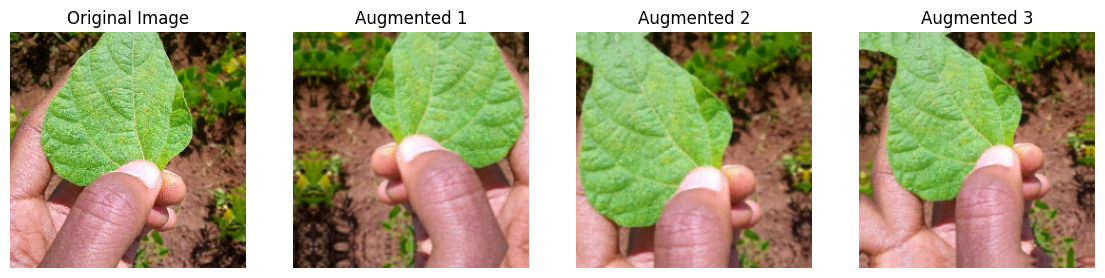

In [7]:
data_augmentor = create_augmentation_model()
image_batch, _ = next(iter(train_dataset))
example_batch_images = image_batch.numpy()

data_augmentor = create_augmentation_model()
sample_image = example_batch_images[0]

images = [tf.keras.utils.array_to_img(sample_image)]

for _ in range(3):
    image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
    image_aug = tf.squeeze(image_aug)
    images.append(tf.keras.utils.array_to_img(image_aug))

fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

plt.show()

CNN Model

In [8]:

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, (3, 3), activation= "relu", padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation= "relu", padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation= "relu", padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation= "relu", padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation= "relu"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(3, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics= ['accuracy', keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall"), keras.metrics.F1Score(average='macro', threshold=0.5, name="f1_score")],
)



In [9]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,520,995 (24.88 MB)

 Trainable params: 6,520,995 (24.88 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def to_categorical_labels(image, label):

    return image, tf.keras.utils.to_categorical(label, num_classes=3)

train_dataset = train_dataset.map(to_categorical_labels)
val_dataset = val_dataset.map(to_categorical_labels)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10,
                                                verbose=1, restore_best_weights=True)

model_history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[earlyStopping],
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - accuracy: 0.3361 - f1_score: 9.3110e-04 - loss: 1.1130 - precision: 0.0556 - recall: 4.6039e-04 - val_accuracy: 0.5149 - val_f1_score: 0.0000e+00 - val_loss: 1.0861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.4091 - f1_score: 1.7450e-04 - loss: 1.0817 - precision: 0.0741 - recall: 8.9031e-05 - val_accuracy: 0.5396 - val_f1_score: 0.0000e+00 - val_loss: 1.0144 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 543ms/step - accuracy: 0.5610 - f1_score: 0.1673 - loss: 0.9867 - precision: 0.8063 - recall: 0.1046 - val_accuracy: 0.6931 - val_f1_score: 0.4559 - val_loss: 0.8478 - val_precision: 0.7857 - val_recall: 0.3267
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 0.6533 - f1_score: 0.5549 - loss: 0.8301 - precision: 0.7858 - recall: 0.4599 - val_accuracy: 0.7079 - val_f1_score: 0.6270 - val_los

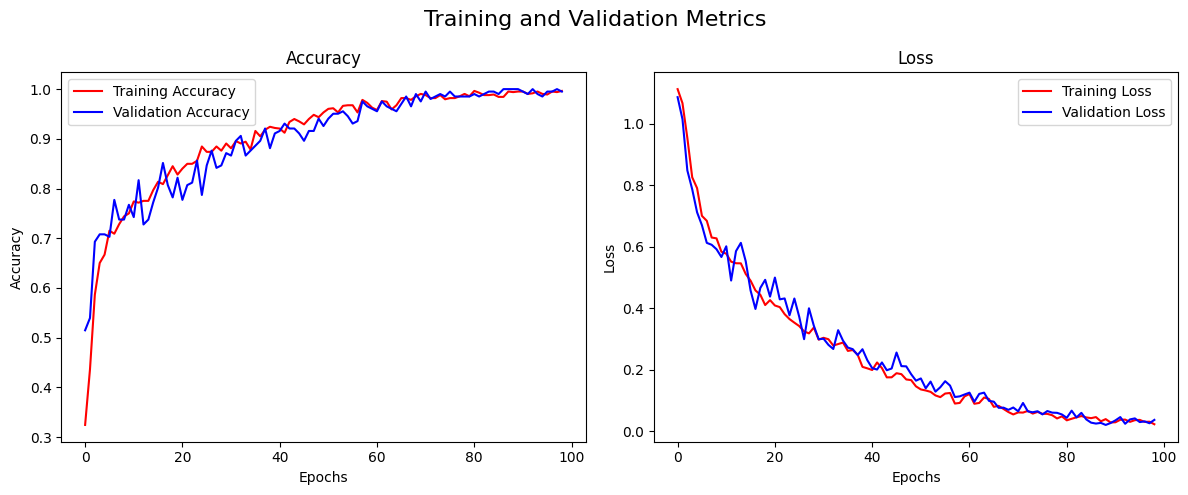

In [11]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Training and Validation Metrics', fontsize=16)

ax[0].plot(epochs, acc, 'r', label="Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label="Validation Accuracy")
ax[0].legend()
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, loss, 'r', label="Training Loss")
ax[1].plot(epochs, val_loss, 'b', label="Validation Loss")
ax[1].legend()
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

In [12]:
scores_val = model.evaluate(val_dataset)

print("")
print(f"Val Accuracy: {scores_val[1]}")
print(f"Val Precision: {scores_val[2]}")
print(f"Val Recall: {scores_val[3]}")
print(f"Val F1 Score: {scores_val[4]}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9964 - f1_score: 0.9963 - loss: 0.0309 - precision: 0.9964 - recall: 0.9964

Val Accuracy: 0.9950494766235352
Val Precision: 0.9950494766235352
Val Recall: 0.9950494766235352
Val F1 Score: 0.9950482845306396


In [13]:
EXPORT_DIR = "/content/drive/MyDrive/Capstone/Models/30_Nov"
tf.saved_model.save(model, EXPORT_DIR)

In [14]:
!pip install tensorflowjs

In [15]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    /content/drive/MyDrive/Capstone/Models/30_Nov\
    /content/drive/MyDrive/Capstone/JS_Models/30_Nov_TFJS

2024-11-30 10:54:21.040803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732964061.071231   30436 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732964061.077518   30436 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-11-30 10:54:30.413033: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1732964070.419672   30436 gpu_device.cc:2022] Created device /job:localhost/replica:0/task